In [11]:
from __future__ import print_function,division
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

get_ipython().run_line_magic('matplotlib','inline')
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def disp_images(images):
    images = np.reshape(images,[images.shape[0],-1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    figure = plt.figure(figsize = (sqrtn,sqrtn))
    gs = gridspec.GridSpec(sqrtn,sqrtn)
    gs.update(wspace = 0.05,hspace = 0.05)
    for i,img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return
def preprocess(x):
    return 2*x-1.0
def deprocess(x):
    return (x+1.0) / 2.0
def count_params():
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count
def session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config = config)
    return session

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(16, 784)


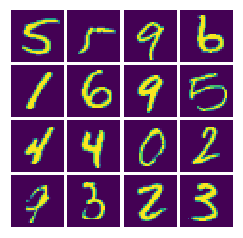

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data',one_hot = False)
disp_images(mnist.train.next_batch(16)[0])# [0] stands for batch x, [1] stands for batch y
print(mnist.train.next_batch(16)[0].shape) #one global para 12

In [4]:
def activation(x, alpha = 0.01):# leaky relu
    a = tf.maximum(x,alpha*x)
    return a
def sample_noise(batch_size,dim):
    random_noise = tf.random_uniform(maxval = 1,minval = -1,shape =[batch_size,dim])
    return random_noise

def get_solvers(lr = 1e-3, beta1 = 0.5):
    d_solver = tf.train.AdamOptimizer(learning_rate = lr,beta1 = beta1)
    g_solver = tf.train.AdamOptimizer(learning_rate = lr,beta1 = beta1)
    return d_solver,g_solver

In [36]:

def generator(x):#for dcgan
    with tf.variable_scope("generator"):#zzz???????????????
        init = tf.contrib.layers.xavier_initializer()
        #reshape
        fc1 = tf.layers.dense(inputs=z,units=4096,activation=tf.nn.relu,name='g_dense_0')
        fc1 = tf.layers.batch_normalization(fc1,name='g_batchnorm_0')
        img = tf.reshape(fc1,[-1,4,4,256]) 
        #deconv1
        img = tf.layers.conv2d_transpose(img,filters=128,kernel_size=4,strides=2,padding='same', #8
                                                kernel_initializer=init,name='g_deconv_1')
        img = tf.layers.batch_normalization(img,name='g_batchnorm_1')
        img = tf.nn.relu(img)
        
        img = tf.layers.conv2d_transpose(img,64,4,strides=2,padding='same', #16
                                                kernel_initializer=init,name='g_deconv_2')
        img = tf.layers.batch_normalization(img,name='g_batchnorm_2')
        img = tf.nn.relu(img)
        
        img = tf.layers.conv2d_transpose(img,1,4,strides=2,padding='same', #32
                                                kernel_initializer=init,name='g_deconv_3')
        img = tf.layers.batch_normalization(img,name='g_batchnorm_3')
        img = tf.nn.relu(img)
        #reshape
        img = tf.reshape(img,[-1,32*32*1]) #1024
        img = tf.layers.dense(inputs=img,units=784,activation=tf.nn.tanh,name='tanh')
        return img
'''
def generator(x):#for wgan
    with tf.variable_scope("generator"):#zzz???????????????
        fc1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1,units=1024,activation=tf.nn.relu)
        img = tf.layers.dense(inputs=fc2,units=784,activation=tf.nn.tanh)
        return img
'''
def train(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,
         show_every=250,print_every=50,batch_size=128,num_epoch=10):
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        if (it % show_every == 0):
            samples = sess.run(G_sample)
            fig = disp_images(samples[:16])# one global para
            plt.show()
            print()
        #fetch the minibatch and train
        minibatch,minibatch_y = mnist.train.next_batch(batch_size)
        _,D_loss_curr = sess.run([D_train_step,D_loss],feed_dict = {x:minibatch})
        _,G_loss_curr = sess.run([G_train_step,G_loss])
        #fetch the minibatch and train
        
        if (it % print_every == 0):
            print('Iter:{}, D:{:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)
        
    fig = disp_images(samples[:16])# one global para
    plt.show()
  
def discriminator(x):#for wgan
    with tf.variable_scope('discriminator'):
        init = tf.contrib.layers.xavier_initializer()
        
        x = tf.layers.dense(x,1024,kernel_initializer=init,name='d_dense_0')
        x = tf.layers.batch_normalization(x,name='d_batchnorm_0')
        x = activation(x)
        
        x = tf.reshape(x,[-1,32,32,1])# one global para
        
        x = tf.layers.conv2d(x,64,4,strides=2,padding='same',  #16
                            kernel_initializer=init,name='d_conv_1')
        x = tf.layers.batch_normalization(x,name='d_batchnorm_1')
        x = activation(x)        

        x = tf.layers.conv2d(x,128,4,strides=2,padding='same',  #8
                            kernel_initializer=init,name='d_conv_2')
        x = tf.layers.batch_normalization(x,name='d_batchnorm_2')
        x = activation(x)      
        
        x = tf.reshape(x,[-1,4096])# i don't know why reshape in 3200
        x = tf.layers.dense(x,1024,kernel_initializer=init,name='d_dense3')
        logits = tf.layers.dense(x,1,kernel_initializer=init,name='logits')
        return logits



''' 
def discriminator(x):#for wgan #备份
    with tf.variable_scope('discriminator'):
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x,[-1,28,28,1])# one global para
        x = tf.layers.conv2d(x,64,4,activation=activation,strides=2,padding='same',
                            kernel_initializer=init,name='conv_0')
        x = tf.layers.conv2d(x,128,4,activation=activation,strides=2,padding='same',
                            kernel_initializer=init,name='conv_1')
        x = tf.layers.batch_normalization(x,name='batchnorm_0')
        x = tf.reshape(x,[-1,4*4*128])# i don't know why reshape in 3200
        x = tf.layers.dense(x,1024,activation=activation,kernel_initializer=init,
                            name='dense_0')
        logits = tf.layers.dense(x,1,kernel_initializer=init,name='logits')
        return logits
        '''  
'''      
def discriminator(x):#for dcgan
    with tf.variable_scope('discriminator'):
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x,[-1,28,28,1])# one global para
        x = tf.layers.conv2d(x,64,4,activation=activation,strides=2,padding='same',
                            kernel_initializer=init,name='conv_0')
        x = tf.layers.conv2d(x,128,4,activation=activation,strides=2,padding='same',
                            kernel_initializer=init,name='conv_1')
        x = tf.layers.batch_normalization(x,name='batchnorm_0')
        x = tf.reshape(x,[-1,4*4*128])# i don't know why reshape in 3200
        x = tf.layers.dense(x,1024,activation=activation,kernel_initializer=init,
                            name='dense_0')
        logits = tf.layers.dense(x,1,kernel_initializer=init,name='logits')
        logits = tf.nn.sigmoid(logits)
        return logits
''' 

"      \ndef discriminator(x):#for dcgan\n    with tf.variable_scope('discriminator'):\n        init = tf.contrib.layers.xavier_initializer()\n        x = tf.reshape(x,[-1,28,28,1])# one global para\n        x = tf.layers.conv2d(x,64,4,activation=activation,strides=2,padding='same',\n                            kernel_initializer=init,name='conv_0')\n        x = tf.layers.conv2d(x,128,4,activation=activation,strides=2,padding='same',\n                            kernel_initializer=init,name='conv_1')\n        x = tf.layers.batch_normalization(x,name='batchnorm_0')\n        x = tf.reshape(x,[-1,4*4*128])# i don't know why reshape in 3200\n        x = tf.layers.dense(x,1024,activation=activation,kernel_initializer=init,\n                            name='dense_0')\n        logits = tf.layers.dense(x,1,kernel_initializer=init,name='logits')\n        logits = tf.nn.sigmoid(logits)\n        return logits\n"

In [37]:
def wgan_gp_loss(logits_real,logits_fake,batch_size,x,G_sample):
    d_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    g_loss = - tf.reduce_mean(logits_fake)
    lam = 10
    eps = tf.random_uniform([batch_size,1],minval=0.0,maxval=1.0)
    x_h = eps*x + (1-eps)*G_sample
    with tf.variable_scope("",reuse=True) as scope:# cannot understand gradient penalty
        grad_d_x_h = tf.gradients(discriminator(x_h),x_h)
    grad_norm = tf.norm(grad_d_x_h[0],axis=1,ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))
    
    d_loss += lam*grad_pen  #this is the key pivot at WGAN-GP
    return d_loss,g_loss


def wgan_loss(logits_real,logits_fake,batch_size,x,G_sample):
    d_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    g_loss = - tf.reduce_mean(logits_fake)
    return d_loss,g_loss

def dcgan_loss(logits_real,logits_fake,batch_size,x,G_sample):
    d_loss = - tf.reduce_mean(tf.log(tf.clip_by_value(logits_real,1e-12,1.0)))-tf.reduce_mean(tf.log(tf.clip_by_value(1 - logits_fake,1e-12,1.0)))
    g_loss = - tf.reduce_mean(tf.log(tf.clip_by_value(logits_fake,1e-12,1.0)))
    return d_loss,g_loss
###################loss

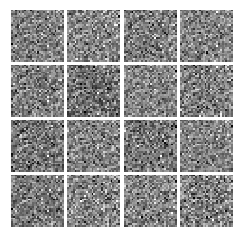


Iter:0, D:7.747, G:-0.1123
Iter:5, D:-0.8136, G:-4.201
Iter:10, D:-3.974, G:4.088
Iter:15, D:-6.825, G:10.05


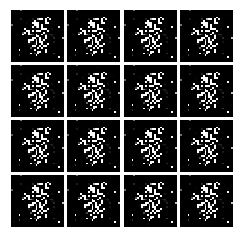


Iter:20, D:-6.61, G:5.004
Iter:25, D:-12.68, G:12.56
Iter:30, D:-3.627, G:3.898
Iter:35, D:-2.485, G:4.71


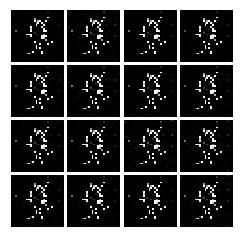


Iter:40, D:-5.361, G:7.656
Iter:45, D:-6.017, G:-2.699
Iter:50, D:-1.39, G:8.752
Iter:55, D:-0.6166, G:4.158


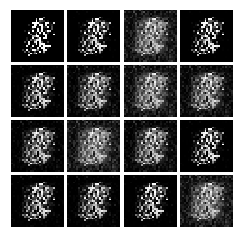


Iter:60, D:-1.964, G:-7.444
Iter:65, D:-1.721, G:0.7048
Iter:70, D:-2.777, G:-0.5153
Iter:75, D:-1.235, G:-9.598


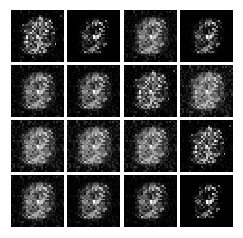


Iter:80, D:-1.977, G:-4.129
Iter:85, D:-2.415, G:-12.7
Iter:90, D:-2.071, G:-10.94
Iter:95, D:-3.306, G:-12.4


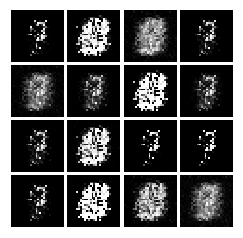


Iter:100, D:-3.952, G:-11.62
Iter:105, D:-5.424, G:-15.71
Iter:110, D:-4.917, G:-9.122
Iter:115, D:-4.477, G:-10.83


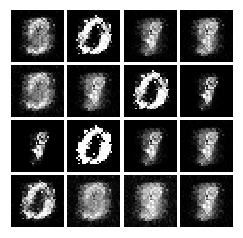


Iter:120, D:-5.075, G:-13.02
Iter:125, D:-3.683, G:-6.487
Iter:130, D:-3.969, G:-7.586
Iter:135, D:-4.2, G:-11.04


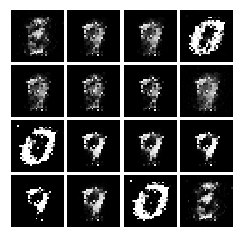


Iter:140, D:-3.688, G:-8.609
Iter:145, D:-3.073, G:-9.339
Iter:150, D:-4.376, G:-8.132
Iter:155, D:-4.684, G:-8.157


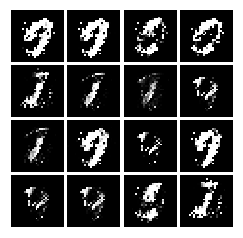


Iter:160, D:-4.975, G:-8.126
Iter:165, D:-3.9, G:-7.802
Iter:170, D:-3.991, G:-5.619
Iter:175, D:-4.131, G:-5.31


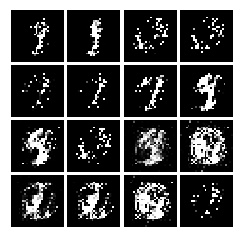


Iter:180, D:-3.188, G:-5.527
Iter:185, D:-3.336, G:-6.414
Iter:190, D:-2.861, G:-6.507
Iter:195, D:-3.491, G:-4.523


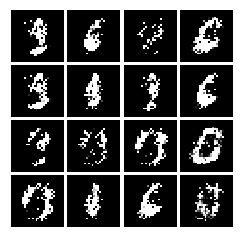


Iter:200, D:-3.816, G:-5.211
Iter:205, D:-4.24, G:-5.563
Iter:210, D:-4.461, G:-5.568
Iter:215, D:-4.114, G:-4.484


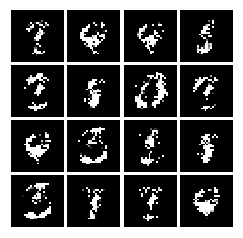


Iter:220, D:-4.325, G:-3.335
Iter:225, D:-3.612, G:-1.733
Iter:230, D:-3.878, G:-2.105
Iter:235, D:-4.079, G:-3.932


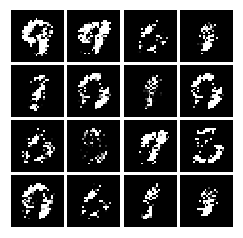


Iter:240, D:-4.529, G:-3.269
Iter:245, D:-4.147, G:-3.084
Iter:250, D:-4.534, G:-2.796
Iter:255, D:-4.767, G:-3.729


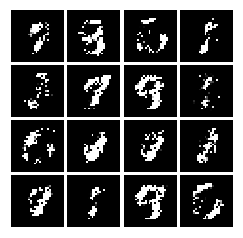


Iter:260, D:-5.03, G:-2.206
Iter:265, D:-4.263, G:-3.616
Iter:270, D:-5.057, G:0.06131
Iter:275, D:-4.671, G:0.4301


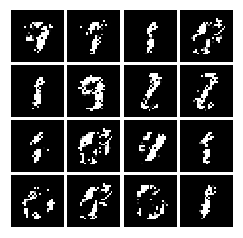


Iter:280, D:-4.295, G:-1.315
Iter:285, D:-4.162, G:-2.373
Iter:290, D:-4.211, G:0.4086
Iter:295, D:-4.09, G:-1.645


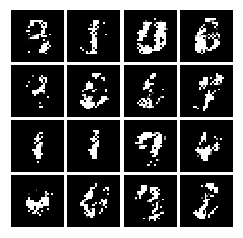


Iter:300, D:-4.367, G:-1.442
Iter:305, D:-3.979, G:-0.4502
Iter:310, D:-4.182, G:0.7525
Iter:315, D:-4.48, G:0.5011


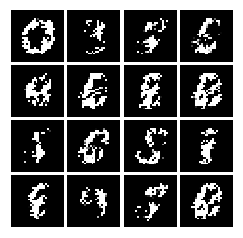


Iter:320, D:-3.561, G:-1.819
Iter:325, D:-3.452, G:1.499
Iter:330, D:-4.105, G:0.211
Iter:335, D:-3.119, G:-0.5484


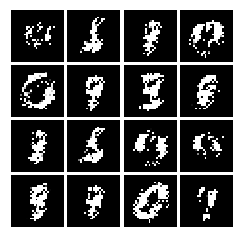


Iter:340, D:-3.0, G:0.2207
Iter:345, D:-3.037, G:0.903
Iter:350, D:-3.524, G:-0.2751
Iter:355, D:-3.11, G:-0.6947


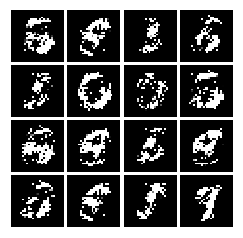


Iter:360, D:-3.411, G:-1.166
Iter:365, D:-3.005, G:-0.5371
Iter:370, D:-3.158, G:-0.1941
Iter:375, D:-3.219, G:0.6072


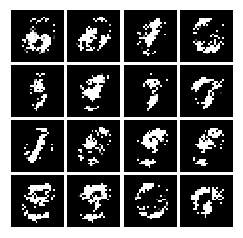


Iter:380, D:-3.019, G:-0.6619
Iter:385, D:-3.265, G:-0.3641
Iter:390, D:-3.361, G:0.1886
Iter:395, D:-2.795, G:-0.5072


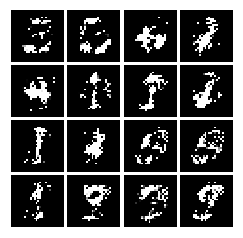


Iter:400, D:-3.147, G:0.635
Iter:405, D:-3.322, G:0.3995
Iter:410, D:-3.224, G:-0.4682
Iter:415, D:-2.988, G:-1.149


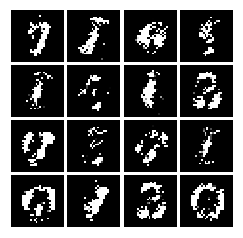


Iter:420, D:-2.803, G:0.1367
Iter:425, D:-2.807, G:-0.5245
Iter:430, D:-2.826, G:0.7735
Iter:435, D:-2.795, G:1.076


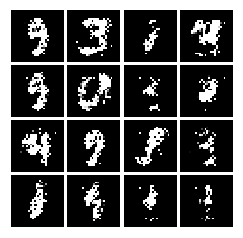


Iter:440, D:-2.527, G:0.196
Iter:445, D:-2.567, G:-0.5125
Iter:450, D:-2.615, G:-0.3305
Iter:455, D:-2.529, G:-0.2077


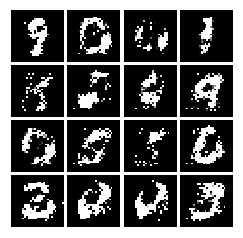


Iter:460, D:-2.3, G:-0.7509
Iter:465, D:-2.916, G:0.5996
Iter:470, D:-2.714, G:0.8164
Iter:475, D:-2.641, G:-1.768


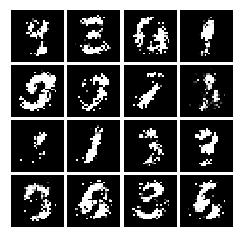


Iter:480, D:-2.441, G:1.333
Iter:485, D:-2.189, G:0.8543
Iter:490, D:-2.336, G:-0.2043
Iter:495, D:-2.568, G:-0.4318


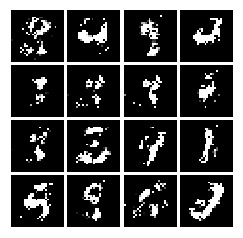


Iter:500, D:-2.566, G:0.3451
Iter:505, D:-2.701, G:-0.1311
Iter:510, D:-1.971, G:0.4091
Iter:515, D:-1.592, G:0.793


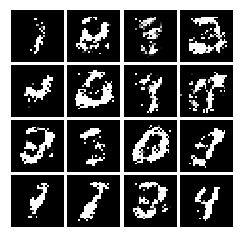


Iter:520, D:-2.128, G:-0.8399
Iter:525, D:-2.262, G:-0.1132
Iter:530, D:-2.39, G:0.648
Iter:535, D:-2.05, G:-0.04933


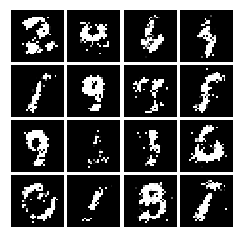


Iter:540, D:-1.763, G:1.467
Iter:545, D:-1.989, G:0.4576
Iter:550, D:-1.873, G:0.2415
Iter:555, D:-1.927, G:1.653


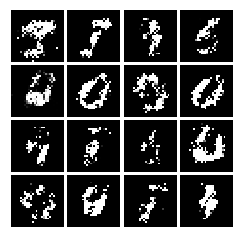


Iter:560, D:-1.891, G:-0.1735
Iter:565, D:-2.003, G:0.2359
Iter:570, D:-2.215, G:-0.2641
Iter:575, D:-2.103, G:-0.2673


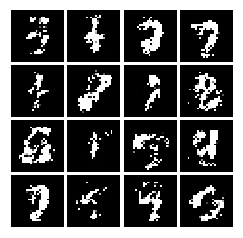


Iter:580, D:-2.166, G:-0.6678
Iter:585, D:-2.27, G:1.047
Iter:590, D:-2.232, G:0.4035
Iter:595, D:-1.909, G:0.05473


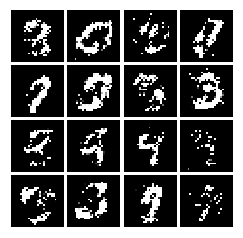


Iter:600, D:-2.174, G:-0.152
Iter:605, D:-1.847, G:1.396
Iter:610, D:-1.996, G:-0.9505
Iter:615, D:-1.835, G:0.441


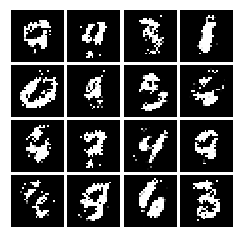


Iter:620, D:-2.251, G:-0.5497
Iter:625, D:-1.83, G:-1.593
Iter:630, D:-2.066, G:1.129
Iter:635, D:-1.858, G:-0.7429


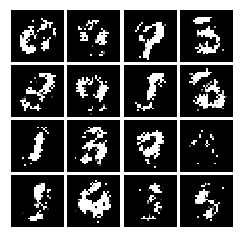


Iter:640, D:-1.994, G:1.17
Iter:645, D:-1.854, G:0.8823
Iter:650, D:-1.928, G:-0.6988
Iter:655, D:-1.829, G:0.2222


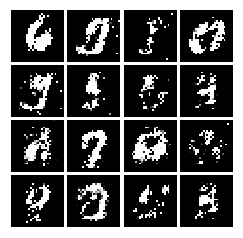


Iter:660, D:-2.327, G:-0.5617
Iter:665, D:-1.942, G:-0.4849
Iter:670, D:-2.03, G:0.2918
Iter:675, D:-1.9, G:-0.2627


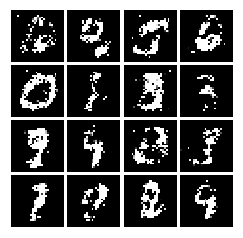


Iter:680, D:-1.569, G:0.0665
Iter:685, D:-1.871, G:0.1394
Iter:690, D:-1.468, G:-0.7889
Iter:695, D:-1.446, G:-1.481


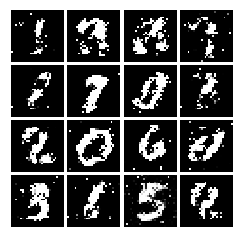


Iter:700, D:-1.562, G:-0.109
Iter:705, D:-1.267, G:-0.637
Iter:710, D:-1.507, G:0.9153
Iter:715, D:-1.548, G:-0.1709


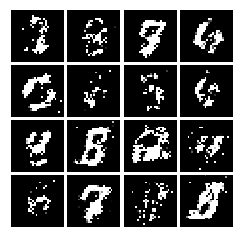


Iter:720, D:-1.526, G:-0.6477
Iter:725, D:-1.61, G:-0.5238
Iter:730, D:-1.49, G:-0.7585
Iter:735, D:-0.9834, G:0.1707


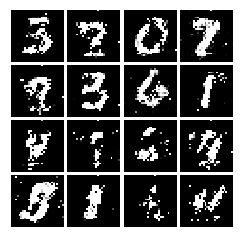


Iter:740, D:-1.28, G:-0.6373
Iter:745, D:-1.785, G:1.189
Iter:750, D:-1.257, G:-1.077
Iter:755, D:-1.558, G:-1.406


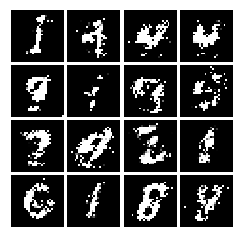


Iter:760, D:-1.331, G:-0.5303
Iter:765, D:-1.391, G:0.1659
Iter:770, D:-1.511, G:-0.7216
Iter:775, D:-1.739, G:-0.6968


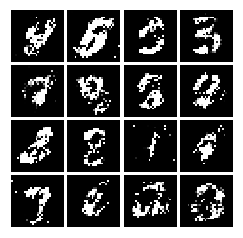


Iter:780, D:-1.575, G:-1.933
Iter:785, D:-1.597, G:-0.4129
Iter:790, D:-1.53, G:-0.004774
Iter:795, D:-1.345, G:-1.213


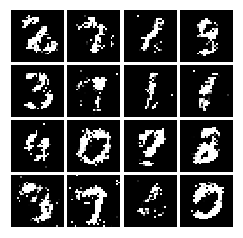


Iter:800, D:-1.643, G:1.035
Iter:805, D:-1.321, G:-0.5127
Iter:810, D:-1.45, G:1.118
Iter:815, D:-1.769, G:-0.8669


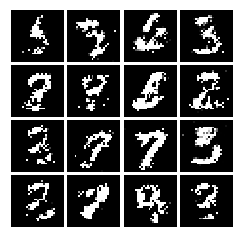


Iter:820, D:-1.664, G:0.2542
Iter:825, D:-1.42, G:-1.448
Iter:830, D:-1.466, G:-0.958
Iter:835, D:-1.424, G:0.7892


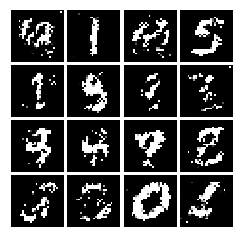


Iter:840, D:-1.415, G:-1.54
Iter:845, D:-1.579, G:0.466
Iter:850, D:-1.722, G:1.098
Iter:855, D:-1.581, G:-0.4194


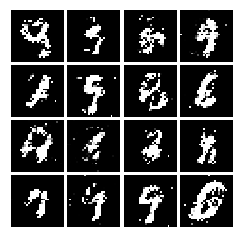


Iter:860, D:-1.078, G:-0.5139
Iter:865, D:-1.365, G:0.1347
Iter:870, D:-1.69, G:-0.4277
Iter:875, D:-1.189, G:0.02709


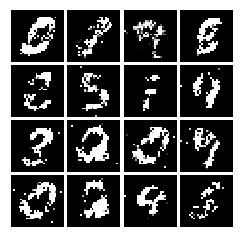


Iter:880, D:-1.253, G:0.1988
Iter:885, D:-1.33, G:-0.1417
Iter:890, D:-1.457, G:-0.371
Iter:895, D:-1.561, G:-0.3648


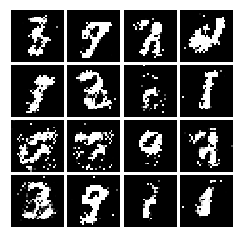


Iter:900, D:-1.348, G:-0.9688
Iter:905, D:-0.8491, G:0.8613
Iter:910, D:-1.418, G:-1.037
Iter:915, D:-1.648, G:0.6933


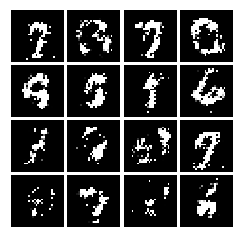


Iter:920, D:-1.509, G:0.6093
Iter:925, D:-1.443, G:-0.5193
Iter:930, D:-1.378, G:0.835
Iter:935, D:-1.413, G:0.1333


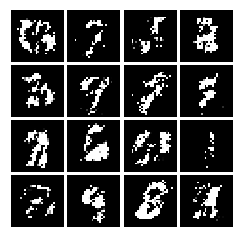


Iter:940, D:-1.445, G:-0.3701
Iter:945, D:-1.28, G:0.2225
Iter:950, D:-1.63, G:0.2888
Iter:955, D:-1.462, G:0.7002


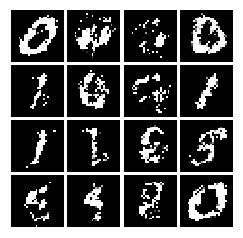


Iter:960, D:-0.7182, G:-0.02815
Iter:965, D:-1.375, G:-0.1207
Iter:970, D:-1.145, G:1.354
Iter:975, D:-1.235, G:0.4442


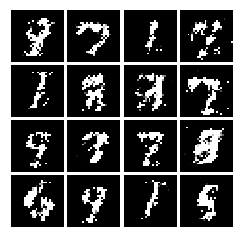


Iter:980, D:-0.9366, G:-3.428
Iter:985, D:-1.271, G:-1.412
Iter:990, D:-0.9959, G:-1.755
Iter:995, D:-1.326, G:1.036


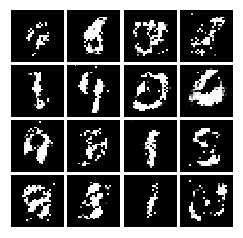


Iter:1000, D:-1.051, G:0.8208
Iter:1005, D:-0.9953, G:-1.182
Iter:1010, D:-1.294, G:-1.104
Iter:1015, D:-0.9748, G:-0.8425


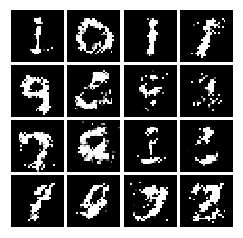


Iter:1020, D:-0.9456, G:-1.151
Iter:1025, D:-0.9444, G:-1.641
Iter:1030, D:-0.9861, G:-0.8619
Iter:1035, D:-1.416, G:-0.1316


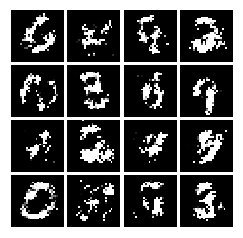


Iter:1040, D:-1.264, G:0.304
Iter:1045, D:-1.049, G:-1.105
Iter:1050, D:-0.9634, G:0.1783
Iter:1055, D:-0.6172, G:0.1927


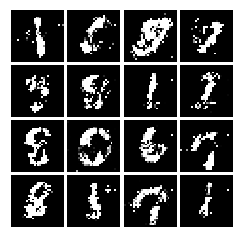


Iter:1060, D:-0.9427, G:-1.515
Iter:1065, D:-0.911, G:1.128
Iter:1070, D:-0.8176, G:-1.064
Iter:1075, D:-0.8026, G:-1.841


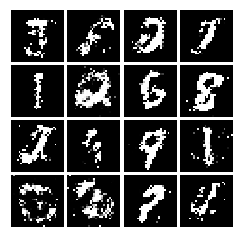


Iter:1080, D:-0.7546, G:-1.102
Iter:1085, D:-0.9104, G:-1.228
Iter:1090, D:-0.7798, G:-0.2551
Iter:1095, D:-1.169, G:1.188


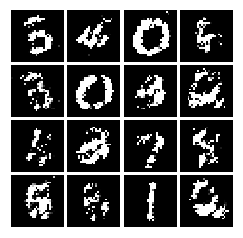


Iter:1100, D:-1.182, G:-2.409
Iter:1105, D:-0.8544, G:0.7193
Iter:1110, D:-1.503, G:-0.4753
Iter:1115, D:-1.183, G:-0.6158


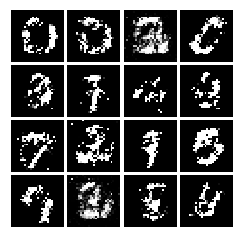


Iter:1120, D:-1.1, G:-0.8826
Iter:1125, D:-0.58, G:-0.6436
Iter:1130, D:-0.6419, G:-0.718
Iter:1135, D:-0.7763, G:0.3255


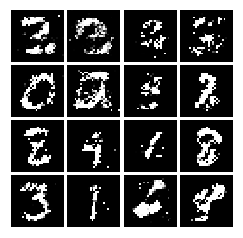


Iter:1140, D:-0.9355, G:-0.2357
Iter:1145, D:-1.028, G:-1.09
Iter:1150, D:-0.6819, G:-0.4161
Iter:1155, D:-0.7196, G:-0.5629


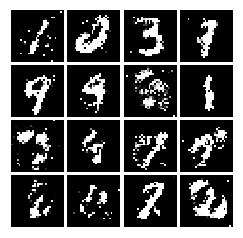


Iter:1160, D:-0.9372, G:-2.018
Iter:1165, D:-0.6736, G:-2.513
Iter:1170, D:-0.8734, G:0.4359
Iter:1175, D:-0.7009, G:-1.275


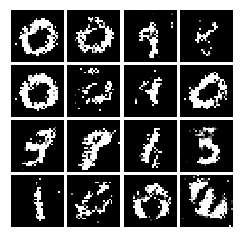


Iter:1180, D:-1.012, G:-3.092
Iter:1185, D:-0.695, G:-2.08
Iter:1190, D:-0.7898, G:-0.2109
Iter:1195, D:-0.8419, G:-1.375


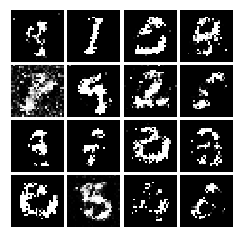


Iter:1200, D:-1.003, G:-1.46
Iter:1205, D:-1.004, G:-0.5146
Iter:1210, D:-1.032, G:-2.027
Iter:1215, D:-1.017, G:-0.303


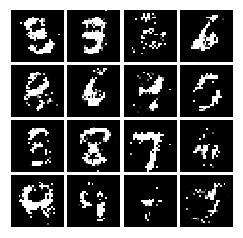


Iter:1220, D:-0.6277, G:0.2478
Iter:1225, D:-1.125, G:-0.3252
Iter:1230, D:-1.009, G:0.495
Iter:1235, D:-0.8261, G:-1.238


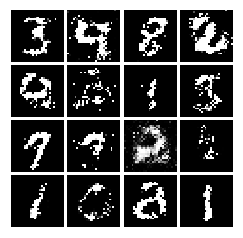


Iter:1240, D:-0.5981, G:-0.7429
Iter:1245, D:-0.9828, G:-1.721
Iter:1250, D:-0.805, G:-0.7797
Iter:1255, D:-0.8719, G:-0.9849


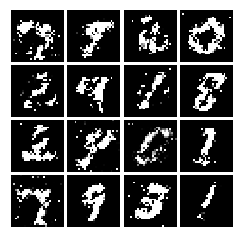


Iter:1260, D:-1.133, G:-0.04814
Iter:1265, D:-0.6814, G:-0.967
Iter:1270, D:-1.024, G:-1.59
Iter:1275, D:-1.008, G:-0.835


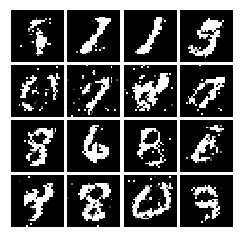


Iter:1280, D:-0.9357, G:-0.59
Iter:1285, D:-1.101, G:-0.9332
Iter:1290, D:-0.8475, G:0.3712
Iter:1295, D:-0.9149, G:-1.277


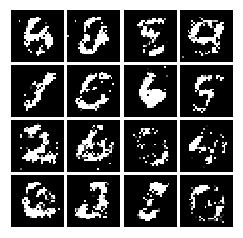


Iter:1300, D:-0.864, G:-1.515
Iter:1305, D:-0.8701, G:-0.2855
Iter:1310, D:-1.067, G:0.1333
Iter:1315, D:-0.8799, G:-1.764


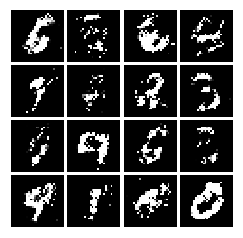


Iter:1320, D:-0.7531, G:-0.4574
Iter:1325, D:-1.22, G:0.2909
Iter:1330, D:-0.7223, G:-0.8583
Iter:1335, D:-0.9178, G:-2.439


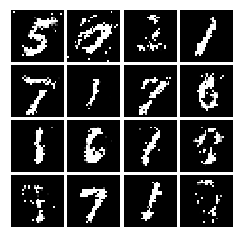


Iter:1340, D:-1.076, G:0.6603
Iter:1345, D:-0.8172, G:-0.8158
Iter:1350, D:-0.7769, G:-0.0406
Iter:1355, D:-1.175, G:-1.449


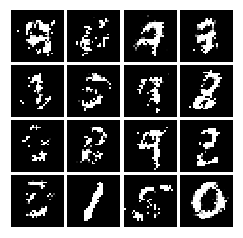


Iter:1360, D:-0.7497, G:-1.246
Iter:1365, D:-0.8006, G:-0.6165
Iter:1370, D:-0.9023, G:-1.697
Iter:1375, D:-0.7656, G:-0.6769


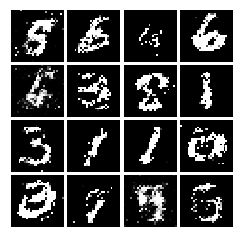


Iter:1380, D:-0.9895, G:-1.166
Iter:1385, D:-0.8606, G:-1.351
Iter:1390, D:-0.7556, G:-0.6394
Iter:1395, D:-1.036, G:0.5523


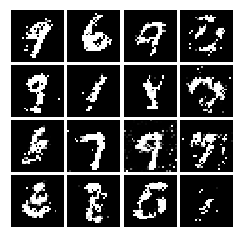


Iter:1400, D:-0.9874, G:0.4468
Iter:1405, D:-1.139, G:-0.547
Iter:1410, D:-0.9071, G:-0.2925
Iter:1415, D:-0.9519, G:-1.713


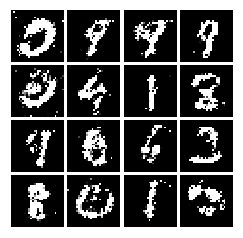


Iter:1420, D:-0.712, G:-2.118
Iter:1425, D:-0.791, G:-1.033
Iter:1430, D:-1.235, G:-1.056
Iter:1435, D:-1.026, G:-0.7882


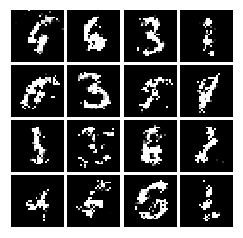


Iter:1440, D:-0.3557, G:-1.418
Iter:1445, D:-1.509, G:-1.391
Iter:1450, D:-0.5503, G:-3.688
Iter:1455, D:-0.639, G:-2.408


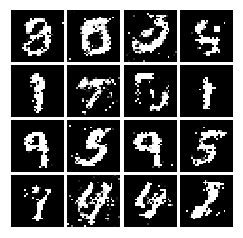


Iter:1460, D:-0.5888, G:-2.114
Iter:1465, D:-1.069, G:-2.974
Iter:1470, D:-0.831, G:-1.051
Iter:1475, D:-0.963, G:-0.1084


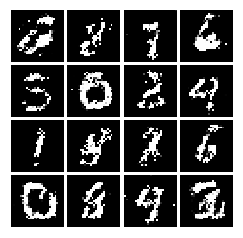


Iter:1480, D:-1.009, G:-0.8007
Iter:1485, D:-0.9926, G:-0.4292
Iter:1490, D:-1.032, G:-0.6628
Iter:1495, D:-0.9719, G:-0.8007


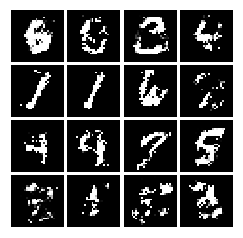


Iter:1500, D:-0.7924, G:-1.888
Iter:1505, D:-1.038, G:-1.59
Iter:1510, D:-0.625, G:-2.278
Iter:1515, D:-1.179, G:-0.6819


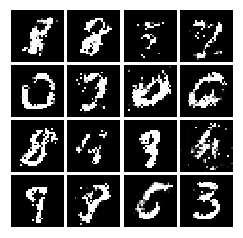


Iter:1520, D:-0.7669, G:-1.129
Iter:1525, D:-1.069, G:-1.311
Iter:1530, D:-1.016, G:-1.62
Iter:1535, D:-0.4843, G:-1.149


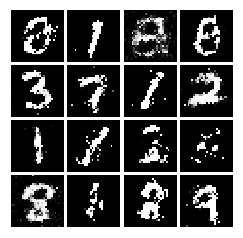


Iter:1540, D:-0.4829, G:-1.648
Iter:1545, D:-0.533, G:-1.708
Iter:1550, D:-0.6601, G:-0.9946
Iter:1555, D:-1.022, G:-2.452


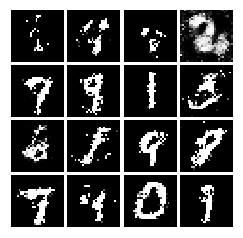


Iter:1560, D:-0.7677, G:-2.365
Iter:1565, D:-1.05, G:-1.71
Iter:1570, D:-0.8427, G:-1.747
Iter:1575, D:-1.325, G:-0.6773


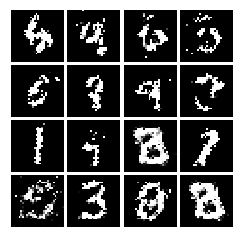


Iter:1580, D:-0.7044, G:-1.438
Iter:1585, D:-1.148, G:-1.752
Iter:1590, D:-0.7987, G:-1.069
Iter:1595, D:-0.8573, G:0.5165


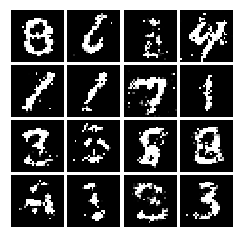


Iter:1600, D:-0.6515, G:-1.051
Iter:1605, D:-1.008, G:-1.001
Iter:1610, D:-0.9191, G:-0.7828
Iter:1615, D:-0.665, G:-1.32


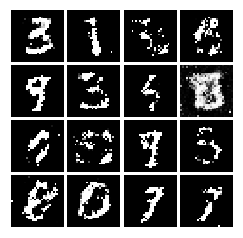


Iter:1620, D:-1.192, G:-0.1815
Iter:1625, D:-1.019, G:0.4445
Iter:1630, D:-0.8087, G:-1.23
Iter:1635, D:-0.866, G:-1.779


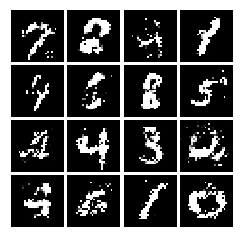


Iter:1640, D:-1.009, G:0.2304
Iter:1645, D:-0.7354, G:-0.4984
Iter:1650, D:-1.07, G:-1.944
Iter:1655, D:-0.7397, G:-3.002


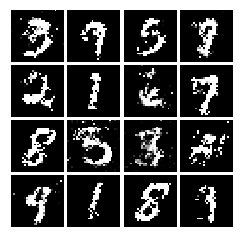


Iter:1660, D:-0.779, G:0.0407
Iter:1665, D:-0.9966, G:-1.359
Iter:1670, D:-0.9836, G:-1.54
Iter:1675, D:-0.8196, G:-1.486


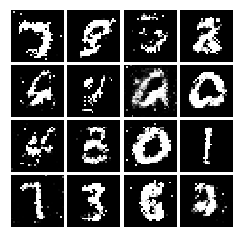


Iter:1680, D:-0.6956, G:-2.309
Iter:1685, D:-0.8298, G:-0.0739
Iter:1690, D:-1.068, G:-0.4636
Iter:1695, D:-0.7517, G:-0.8696


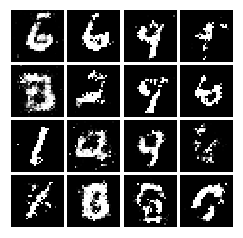


Iter:1700, D:-0.4037, G:-2.237
Iter:1705, D:-0.9712, G:0.08595
Iter:1710, D:-0.4629, G:-2.435
Iter:1715, D:-0.942, G:-0.8677


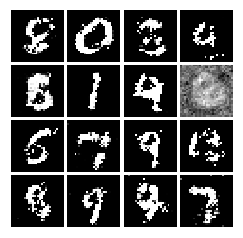


Iter:1720, D:-0.6527, G:-1.003
Iter:1725, D:-0.7885, G:-1.306
Iter:1730, D:-0.6964, G:-1.741
Iter:1735, D:-0.2812, G:-3.653


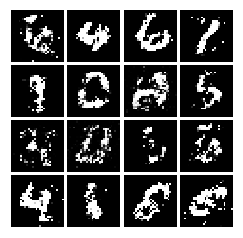


Iter:1740, D:-0.6936, G:-1.396
Iter:1745, D:-0.5389, G:-0.1742
Iter:1750, D:-0.7487, G:-2.565
Iter:1755, D:-0.737, G:-1.972


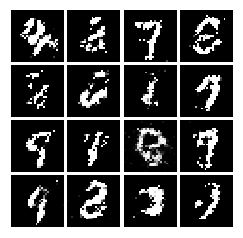


Iter:1760, D:-0.7852, G:-1.123
Iter:1765, D:-0.6467, G:-1.996
Iter:1770, D:-0.8206, G:-2.306
Iter:1775, D:-0.9149, G:-1.501


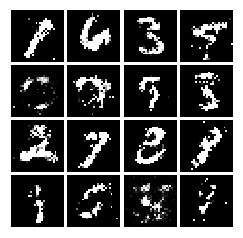


Iter:1780, D:-0.9018, G:-2.093
Iter:1785, D:-0.7618, G:-3.223
Iter:1790, D:-0.648, G:-2.915
Iter:1795, D:-0.8137, G:-1.822


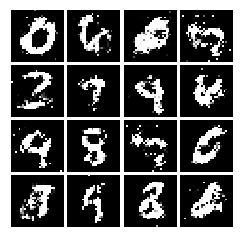


Iter:1800, D:-0.5744, G:-2.076
Iter:1805, D:-0.4822, G:-1.44
Iter:1810, D:-0.5449, G:-3.906
Iter:1815, D:-0.7882, G:-2.443


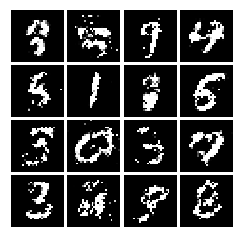


Iter:1820, D:-0.7243, G:-2.259
Iter:1825, D:-0.7842, G:-1.67
Iter:1830, D:-0.9309, G:-2.21
Iter:1835, D:-0.5182, G:-1.268


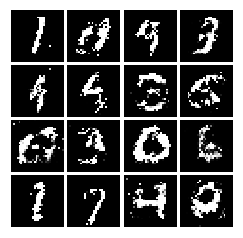


Iter:1840, D:-0.5201, G:-2.081
Iter:1845, D:-0.7055, G:-0.3233
Iter:1850, D:-0.7355, G:-1.205
Iter:1855, D:-0.6204, G:-2.3


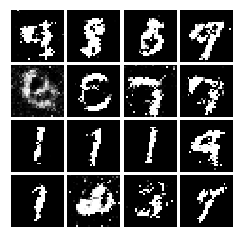


Iter:1860, D:-0.998, G:-1.607
Iter:1865, D:-0.7418, G:-1.482
Iter:1870, D:-0.6906, G:-0.0241
Iter:1875, D:-0.8169, G:-2.205


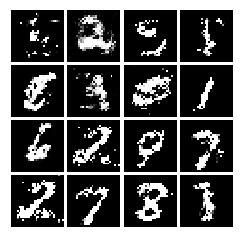


Iter:1880, D:-1.003, G:-3.05
Iter:1885, D:-0.7226, G:-0.718
Iter:1890, D:-0.8143, G:-2.35
Iter:1895, D:-0.9892, G:-2.326


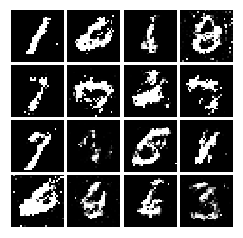


Iter:1900, D:-0.9084, G:-1.401
Iter:1905, D:-0.7517, G:-2.574
Iter:1910, D:-0.5366, G:-3.312
Iter:1915, D:-0.5805, G:1.081


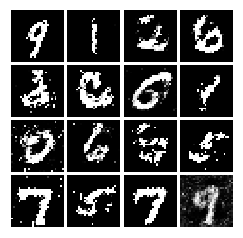


Iter:1920, D:-0.7758, G:-1.96
Iter:1925, D:-0.661, G:-0.9696
Iter:1930, D:-0.5319, G:-0.3461
Iter:1935, D:-0.9312, G:-1.039


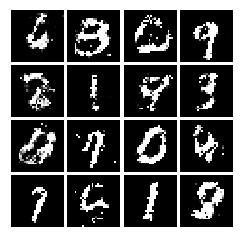


Iter:1940, D:-0.4948, G:-1.45
Iter:1945, D:-0.6884, G:-0.8953
Iter:1950, D:-0.5789, G:-2.148
Iter:1955, D:-0.9546, G:-0.683


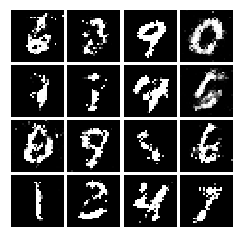


Iter:1960, D:-0.8961, G:-1.238
Iter:1965, D:-0.7275, G:-2.677
Iter:1970, D:-0.9434, G:-1.733
Iter:1975, D:-0.8101, G:-0.3981


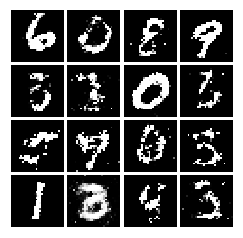


Iter:1980, D:-0.7963, G:-1.152
Iter:1985, D:-0.7419, G:-0.6327
Iter:1990, D:-0.7564, G:-2.26
Iter:1995, D:-0.8172, G:-2.336


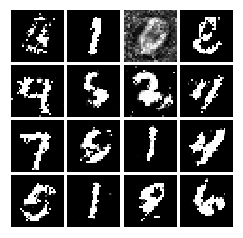


Iter:2000, D:-0.8803, G:-1.828
Iter:2005, D:-0.9596, G:-3.516
Iter:2010, D:-0.8805, G:-3.341
Iter:2015, D:-0.8577, G:-2.149


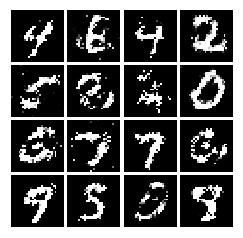


Iter:2020, D:-0.7555, G:-2.993
Iter:2025, D:-0.5965, G:-1.049
Iter:2030, D:-0.8903, G:-2.039
Iter:2035, D:-0.8364, G:-0.2582


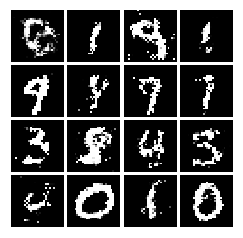


Iter:2040, D:-0.7409, G:-2.179
Iter:2045, D:-0.6733, G:-1.352
Iter:2050, D:-0.7745, G:-3.027
Iter:2055, D:-0.5686, G:-1.737


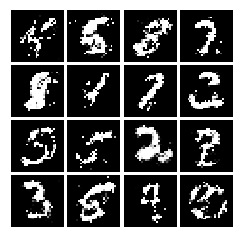


Iter:2060, D:-0.9712, G:-1.538
Iter:2065, D:-0.5826, G:-1.244
Iter:2070, D:-0.8028, G:-1.579
Iter:2075, D:-0.8041, G:-0.9046


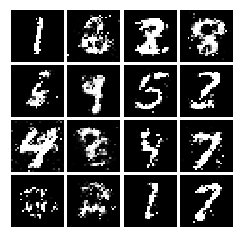


Iter:2080, D:-0.9046, G:-1.434
Iter:2085, D:-0.5775, G:-4.56
Iter:2090, D:-0.5724, G:-3.559
Iter:2095, D:-0.8633, G:-0.4457


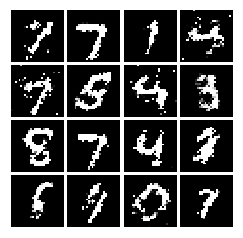


Iter:2100, D:-0.5921, G:-0.2495
Iter:2105, D:-0.606, G:-0.1267
Iter:2110, D:-0.6817, G:-2.647
Iter:2115, D:-0.7459, G:-1.249


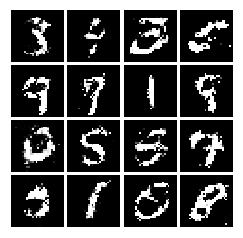


Iter:2120, D:-0.6117, G:-0.07623
Iter:2125, D:-0.7199, G:-2.062
Iter:2130, D:-0.2788, G:-1.467
Iter:2135, D:-0.8196, G:-1.714


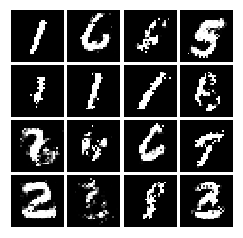


Iter:2140, D:-0.8801, G:-0.1546
Iter:2145, D:-0.8503, G:-0.8974
Final images


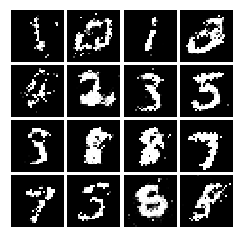

In [38]:
tf.reset_default_graph()
batch_size = 128
noise_dim = 96
x = tf.placeholder(tf.float32,[None,784])
z = sample_noise(batch_size,noise_dim)
G_sample = generator(z)

with tf.variable_scope("") as scope:
    logits_real = discriminator(preprocess(x))
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)
    
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')
d_solver,g_solver = get_solvers()

d_loss,g_loss = wgan_gp_loss(logits_real,logits_fake,128,x,G_sample) #change loss oneonoeneone -----------------------
d_train_step = d_solver.minimize(d_loss,var_list=D_vars)
g_train_step = g_solver.minimize(g_loss,var_list=G_vars)
d_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
g_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

with session() as sess:
    try:
        with tf.device("/gpu:0") as dev:
            sess.run(tf.global_variables_initializer())
            train(sess,g_train_step,g_loss,d_train_step,d_loss,g_extra_step,d_extra_step,
                  show_every=20,print_every=5,batch_size=128,num_epoch=5)    
    except tf.errors.InvalidArgumentError:
        print("no gpu found, please use Google Cloud if you want GPU acceleration") 


In [92]:
#################loss
def wgan_gp_loss(logits_real,logits_fake,batch_size,x,G_sample):
    d_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    g_loss = - tf.reduce_mean(logits_fake)
    lam = 10
    eps = tf.random_uniform([batch_size,1],minval=0.0,maxval=1.0)
    x_h = eps*x + (1-eps)*G_sample
    with tf.variable_scope("",reuse=True) as scope:# cannot understand gradient penalty
        grad_d_x_h = tf.gradients(discriminator(x_h),x_h)
    grad_norm = tf.norm(grad_d_x_h[0],axis=1,ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))
    
    d_loss += lam*grad_pen  #this is the key pivot at WGAN-GP
    return d_loss,g_loss

def wgan_loss(logits_real,logits_fake,batch_size,x,G_sample):
    d_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    g_loss = - tf.reduce_mean(logits_fake)
    return d_loss,g_loss

def dcgan_loss(logits_real,logits_fake,batch_size,x,G_sample):
    d_loss = - tf.reduce_mean(tf.log(logits_real+1e-10))-tf.reduce_mean(tf.log(1 - logits_fake+1e-10))
    g_loss = - tf.reduce_mean(tf.log(logits_fake+1e-10))
    return d_loss,g_loss
###################loss

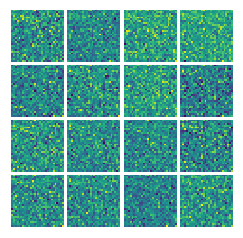


Iter:0, D:-0.03421, G:-0.0369
Final images


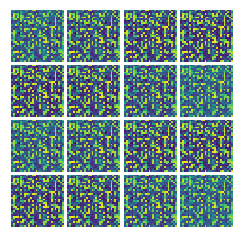

Final images


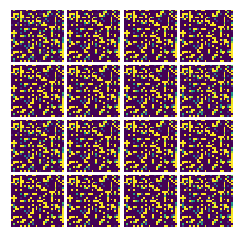

Final images


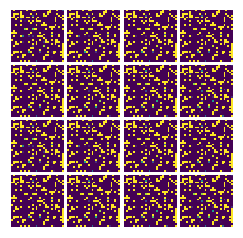

Final images


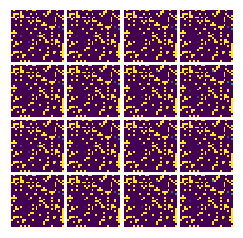

Final images


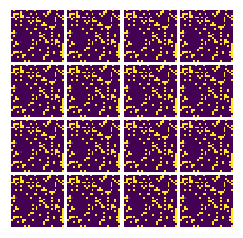

Iter:5, D:-8.041, G:-23.36
Final images


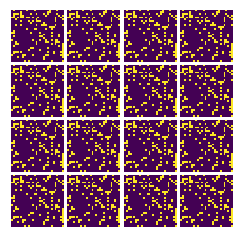

Final images


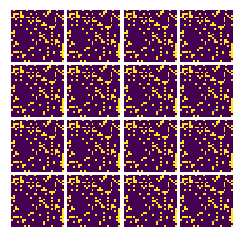

Final images


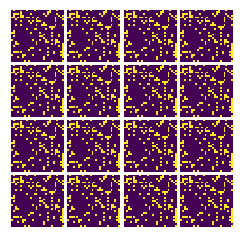

Final images


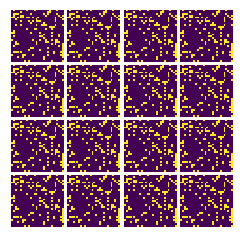

Final images


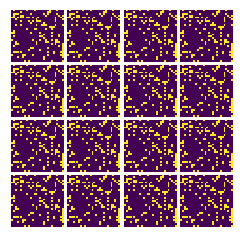

Iter:10, D:-132.3, G:-106.9
Final images


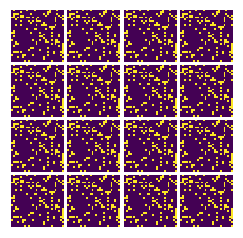

Final images


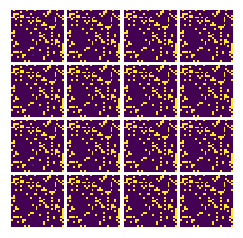

Final images


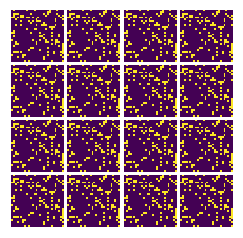

Final images


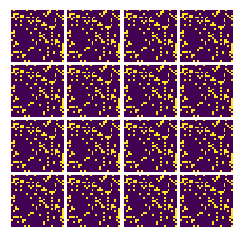

In [ ]:
log_dir='e://python3'
sess = tf.InteractiveSession()
train_writer = tf.summary.FileWriter(log_dir + '/DCGAN',tf.get_default_graph())
